# Check alpha constraints for Powerspectrum

### Import all modules

In [19]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import scipy.interpolate as interpolate

import pandas as pd

import scipy.stats
from ast import literal_eval

## Load data

In [20]:
data=np.load("z0.50/glam_pk_0114.npz")

In [49]:
data.files

['k', 'bkr', 'bkrm']

In [22]:
k,pkrm,pr= data["k"],data["bkrm"],data["bkr"]

## Interpolation

#### 1. scipy.interpolate

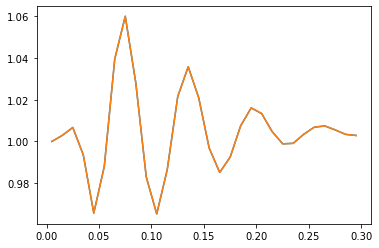

In [23]:
ff=interpolate.interp1d(k,pkrm)
plt.plot(k,pkrm)
plt.plot(k,ff(k))

### Masking at kmin,kmax

In [30]:
kmin=0.005
kmax=0.21
def cutslice(kmin,kmax):
    is_good = np.ones(k.shape[0], '?')
    is_good &= (k > kmin) & (k < kmax)
    kg = k[is_good]
    pg = pkrm[is_good]
    nbins, nmocks = pr[is_good, :].shape
    hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
    #print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}')
    cov = np.cov(pr[is_good, :], rowvar=True)*hartlapf / nmocks
    icov = inv(cov)
    
    return kg,pg,cov

In [31]:
kg,pg,cov=cutslice(kmin,kmax)

## Chi-square test

In [32]:
def chisq(obs, exp, cov):
    delta=obs-exp
    cov_inv=inv(cov)
    return delta.dot(cov_inv.dot(delta))

In [33]:
alp=np.linspace(0.95,1.05,2000)

def chisq_alp(k,alp,cov):
    error=[]
    obs=ff(k)
    for i in alp:
        exp=ff(k*i)
        error.append(np.abs(chisq(obs, exp, cov)))
    return error
    

In [34]:
error=chisq_alp(kg,alp,cov)

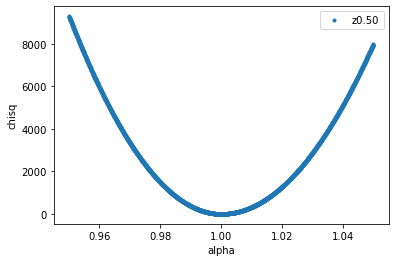

In [35]:
plt.plot(alp,error,".",label="z0.50")
#plt.xlim(0.995,1.005)
#plt.ylim(-0.1,4)
plt.xlabel("alpha")
plt.ylabel("chisq")
plt.legend()
#plt.savefig("chsq.png")

### 2. sigma_alpha vs kmax

In [36]:
alp=np.linspace(0.985,1.015,20000)

kmin=0.005
kmax_min=0.05
kmax_max=0.21
all_errors=[]
all_kmax=[]
for kmax in reversed(np.unique(k)):
    if kmax>kmax_min and kmax<kmax_max:
        ki,pki,covi=cutslice(kmin,kmax)
        errori=chisq_alp(ki,alp,covi)
        all_errors.append(errori)
        all_kmax.append(kmax)
        print(kmax,np.min(errori))

0.20500000000000004 1.6208232214050622e-06
0.19500000000000003 1.589124750528288e-06
0.18500000000000003 1.5394095121525492e-06
0.17500000000000002 1.2289997167370881e-06
0.165 1.106088201523104e-06
0.155 1.0544221229962052e-06
0.145 7.529376064258783e-07
0.13499999999999998 5.88438579608792e-07
0.12499999999999997 4.917662023559357e-07
0.11499999999999998 3.1571196654082296e-07
0.10499999999999998 1.7743561833129615e-07
0.09499999999999999 1.4297920803595714e-07
0.08499999999999999 5.968544610575631e-08
0.075 3.4137887009726795e-08
0.065 1.1535137169164958e-08
0.05500000000000001 3.89609723872869e-09


Text(0.5, 0, 'alpha')

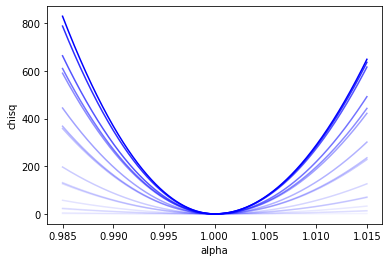

In [37]:
alpha = np.geomspace(1,0.05,len(all_errors))
for i,error in enumerate(all_errors):
    plt.plot(alp,error,alpha=alpha[i],color = 'b')
plt.ylabel("chisq")
plt.xlabel("alpha")
#plt.ylim(-10,3000)
#plt.xlim(0.98,1.02)
#plt.savefig("all_chisq.png")

### 1sigma constriant vs kmax

In [38]:
def find_1sigma(error,llim,rlim):
    least=np.min(error)
    ffe=interpolate.interp1d(alp,error,fill_value="extrapolate")
    alp2=np.linspace(0.985,1.015,2000000)
    print(min(ffe(alp2)))
    ind=np.where((ffe(alp2)<1+least+rlim) & (ffe(alp2)>1+least-llim))
    print(ind)
    left=ind[0][0]
    right=ind[0][-1]
    print(alp2[left],alp2[right])
    return alp2[right]-alp2[left]

In [39]:
sigma=[]
count=1
for i in all_errors:
    sigma.append(find_1sigma(i,1e-4/count,1e-4/count))
    count=count+0.5

1.6230907805129405e-06
(array([ 965262,  965263,  965264, 1039274, 1039275, 1039276, 1039277]),)
0.9994789372394686 1.0005891627945813
1.5910332191711134e-06
(array([ 964364,  964365, 1039664, 1039665, 1039666]),)
0.9994654672327336 1.0005949977974988
1.5400033537996803e-06
(array([ 961161,  961162, 1040300, 1040301]),)
0.9994174222087111 1.0006045228022613
1.23048269922449e-06
(array([ 959497,  959498, 1045103, 1045104]),)
0.999392462196231 1.0006765678382838
1.1079411950266795e-06
(array([ 958826,  958827, 1047543, 1047544]),)
0.9993823971911986 1.000713167856584
1.0547023563276435e-06
(array([ 952543,  952544, 1048694, 1048695]),)
0.9992881521440761 1.0007304328652165
7.537742855772184e-07
(array([ 947853, 1057624, 1057625]),)
0.999217802108901 1.0008643829321915
5.899801527441472e-07
(array([ 947153, 1065183, 1065184]),)
0.999207302103651 1.0009777679888838
4.921595485036376e-07
(array([ 928696, 1066226, 1066227]),)
0.9989304469652235 1.0009934129967064
3.1577207784774153e-07
(arra

In [40]:
len(sigma)

16

Text(0, 0.5, '1sigma_alpha')

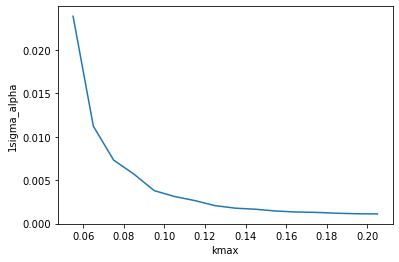

In [41]:
plt.plot(all_kmax,sigma)
plt.xlabel("kmax")
plt.ylabel("1sigma_alpha")
#plt.savefig("1sigma_alpha_vs_kmax.png")

In [46]:
np.savez('pk_1sigma.npz', kmax=all_kmax, sigma=sigma)
